In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
import torch
from xgboost import XGBClassifier
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    text = re.sub(r'\s+', ' ', text).strip()

    authors = [
        'чехов', 'чехова', 'чехову', 'чеховым', 'чехове', 'антон', 'антона', 'антону', 'антоном', 'антоне', 'павлович', 'павловича', 'павловичу', 'павловичем', 'павловиче',
        'куприн', 'куприна', 'куприну', 'куприным', 'куприне', 'александр', 'александра', 'александру', 'александром', 'александре', 'иванович', 'ивановича', 'ивановичу', 'ивановичем', 'ивановиче',
        'бунин', 'бунина', 'бунину', 'буниным', 'бунине', 'иван', 'ивана', 'ивану', 'иваном', 'иване', 'алексеевич', 'алексеевича', 'алексеевичу', 'алексеевичем', 'алексеевиче',
        'карамзин', 'карамзина', 'карамзину', 'карамзиным', 'карамзине', 'николай', 'николая', 'николаю', 'николаем', 'николае', 'михайлович', 'михайловича', 'михайловичу', 'михайловичем', 'михайловиче',
        'достоевский', 'достоевского', 'достоевскому', 'достоевским', 'достоевском', 'федор', 'федора', 'федору', 'федором', 'федоре', 'федька', 'феденька', 'михайлович', 'михайловича', 'михайловичу', 'михайловичем', 'михайловиче',
        'лермонтов', 'лермонтова', 'лермонтову', 'лермонтовым', 'лермонтове', 'михаил', 'михаила', 'михаилу', 'михаилом', 'михаиле', 'миша', 'мишель', 'юрьевич', 'юрьевича', 'юрьевичу', 'юрьевичем', 'юрьевиче',
        'пушкин', 'пушкина', 'пушкину', 'пушкиным', 'пушкине', 'александр', 'александра', 'александру', 'александром', 'александре', 'саша', 'сергеевич', 'сергеевича', 'сергеевичу', 'сергеевичем', 'сергеевиче',
        'мамин', 'мамина', 'мамину', 'маминым', 'мамине', 'сибиряк', 'сибиряка', 'сибиряку', 'сибиряком', 'сибиряке', 'мамин-сибиряк', 'мамина-сибиряка', 'мамину-сибиряку', 'маминым-сибиряком', 'мамине-сибиряке', 'дмитрий', 'дмитрия', 'дмитрию', 'дмитрием', 'дмитрии', 'наркисович', 'наркисовича', 'наркисовичу', 'наркисовичем', 'наркисовиче',
        'гоголь', 'гоголя', 'гоголю', 'гоголем', 'гоголе', 'николай', 'николая', 'николаю', 'николаем', 'николае', 'васильевич', 'васильевича', 'васильевичу', 'васильевичем', 'васильевиче',
        'тургенев', 'тургенева', 'тургеневу', 'тургеневым', 'тургеневе', 'иван', 'ивана', 'ивану', 'иваном', 'иване', 'сергеевич', 'сергеевича', 'сергеевичу', 'сергеевичем', 'сергеевиче',
        'салтыков', 'салтыкова', 'салтыкову', 'салтыковым', 'салтыкове', 'щедрин', 'щедрина', 'щедрину', 'щедрином', 'щедрине', 'салтыков-щедрин', 'салтыкова-щедрина', 'салтыкову-щедрину', 'салтыковым-щедрином', 'салтыкове-щедрине', 'михаил', 'михаила', 'михаилу', 'михаилом', 'михаиле', 'евграфович', 'евграфовича', 'евграфовичу', 'евграфовичем', 'евграфовиче',
        'блок', 'блока', 'блоку', 'блоком', 'блоке', 'александр', 'александра', 'александру', 'александром', 'александре', 'александрович', 'александровича', 'александровичу', 'александровичем', 'александровиче',
        'есенин', 'есенина', 'есенину', 'есениным', 'есенине', 'сергей', 'сергея', 'сергею', 'сергеем', 'сергее', 'александрович', 'александровича', 'александровичу', 'александровичем', 'александровиче',
        'а.п.', 'а. п.', 'с.а.', 'с. а.', 'ф.м.', 'ф. м.', 'н.в.', 'н. в.', 'и.с.', 'и. с.', 'м.е.', 'м. е.'
    ]
    
    for author in authors:
        text = text.replace(author, '')
    
    return text
    

def load_data(file_path):
    df = pd.read_csv(file_path)

    df = df.drop(index=1918) # как и в прошлых экспериментах
    df = df.reset_index(drop=True)

    df['text'] = df['text'].apply(preprocess_text)

    print(f"Загружено {len(df)} записей")
    print(f"Уникальные авторы: {df['author'].unique()}")
    
    return df


file_path = 'https://storage.yandexcloud.net/auth-def-2024/datasets/meta_table_with_texts.csv'

df = load_data(file_path)

Загружено 2564 записей
Уникальные авторы: ['Пушкин Александр Сергеевич' 'Карамзин Николай Михайлович'
 'Гоголь Николай Васильевич' 'Мамин-Сибиряк Дмитрий Наркисович'
 'Салтыков-Щедрин Михаил Евграфович' 'Куприн Александр Иванович'
 'Бунин Иван Алексеевич' 'Блок Александр Александрович'
 'Достоевский Федор Михайлович' 'Лермонтов Михаил Юрьевич'
 'Чехов Антон Павлович' 'Тургенев Иван Сергеевич'
 'Есенин Сергей Александрович']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values, 
    df['author'].values, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['author'].values
)
    
print(f"Обучающая выборка: {X_train.shape[0]} текстов")
print(f"Тестовая выборка: {X_test.shape[0]} текстов")

Обучающая выборка: 2051 текстов
Тестовая выборка: 513 текстов


In [7]:
def get_bert_embeddings(texts, tokenizer, bert_model, max_length=128):
    bert_model.eval()
    bert_model.to(device)
    
    embeddings = []
    
    batch_size = 8
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        
        encoded_inputs = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=max_length, 
            return_tensors='pt'
        )
        
        encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
        
        with torch.no_grad():
            outputs = bert_model(**encoded_inputs)
        
        attention_mask = encoded_inputs['attention_mask']
        last_hidden_state = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        mean_embeddings = sum_embeddings / sum_mask
        
        batch_embeddings = mean_embeddings.cpu().numpy()
        embeddings.extend(batch_embeddings)
        
        print(f"Обработано {min(i+batch_size, len(texts))}/{len(texts)} текстов")
    
    return np.array(embeddings)


tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
X_train_embeddings = get_bert_embeddings(X_train, tokenizer=tokenizer, bert_model=bert_model)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Обработано 8/2051 текстов
Обработано 16/2051 текстов
Обработано 24/2051 текстов
Обработано 32/2051 текстов
Обработано 40/2051 текстов
Обработано 48/2051 текстов
Обработано 56/2051 текстов
Обработано 64/2051 текстов
Обработано 72/2051 текстов
Обработано 80/2051 текстов
Обработано 88/2051 текстов
Обработано 96/2051 текстов
Обработано 104/2051 текстов
Обработано 112/2051 текстов
Обработано 120/2051 текстов
Обработано 128/2051 текстов
Обработано 136/2051 текстов
Обработано 144/2051 текстов
Обработано 152/2051 текстов
Обработано 160/2051 текстов
Обработано 168/2051 текстов
Обработано 176/2051 текстов
Обработано 184/2051 текстов
Обработано 192/2051 текстов
Обработано 200/2051 текстов
Обработано 208/2051 текстов
Обработано 216/2051 текстов
Обработано 224/2051 текстов
Обработано 232/2051 текстов
Обработано 240/2051 текстов
Обработано 248/2051 текстов
Обработано 256/2051 текстов
Обработано 264/2051 текстов
Обработано 272/2051 текстов
Обработано 280/2051 текстов
Обработано 288/2051 текстов
Обраб

In [8]:
def train_xgboost_model(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1],  # L1 регуляризация
        'reg_lambda': [0, 0.1]  # L2 регуляризация
    }

    # param_grid = { # для теста
    #     'max_depth': [7],
    #     'learning_rate': [0.1],
    #     'n_estimators': [200],
    #     'subsample': [0.8],
    #     'reg_alpha': [0.1],
    #     'reg_alpha': [0.1],
    # }

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    )
    
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        scoring='f1_weighted',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    best_model = grid_search.best_estimator_
    print(f"Лучшие параметры: {grid_search.best_params_}")
    
    return best_model, grid_search.cv_results_


xgb_model, cv_results = train_xgboost_model(
    X_train_embeddings, 
    y_train_encoded
)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}


In [9]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred)
    
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Отчет по классификации:")
    print(report)
    return


X_test_embeddings = get_bert_embeddings(X_test, tokenizer=tokenizer, bert_model=bert_model)
y_test_encoded = label_encoder.transform(y_test)

evaluate_model(xgb_model, X_test_embeddings, y_test_encoded)

Обработано 8/513 текстов
Обработано 16/513 текстов
Обработано 24/513 текстов
Обработано 32/513 текстов
Обработано 40/513 текстов
Обработано 48/513 текстов
Обработано 56/513 текстов
Обработано 64/513 текстов
Обработано 72/513 текстов
Обработано 80/513 текстов
Обработано 88/513 текстов
Обработано 96/513 текстов
Обработано 104/513 текстов
Обработано 112/513 текстов
Обработано 120/513 текстов
Обработано 128/513 текстов
Обработано 136/513 текстов
Обработано 144/513 текстов
Обработано 152/513 текстов
Обработано 160/513 текстов
Обработано 168/513 текстов
Обработано 176/513 текстов
Обработано 184/513 текстов
Обработано 192/513 текстов
Обработано 200/513 текстов
Обработано 208/513 текстов
Обработано 216/513 текстов
Обработано 224/513 текстов
Обработано 232/513 текстов
Обработано 240/513 текстов
Обработано 248/513 текстов
Обработано 256/513 текстов
Обработано 264/513 текстов
Обработано 272/513 текстов
Обработано 280/513 текстов
Обработано 288/513 текстов
Обработано 296/513 текстов
Обработано 304

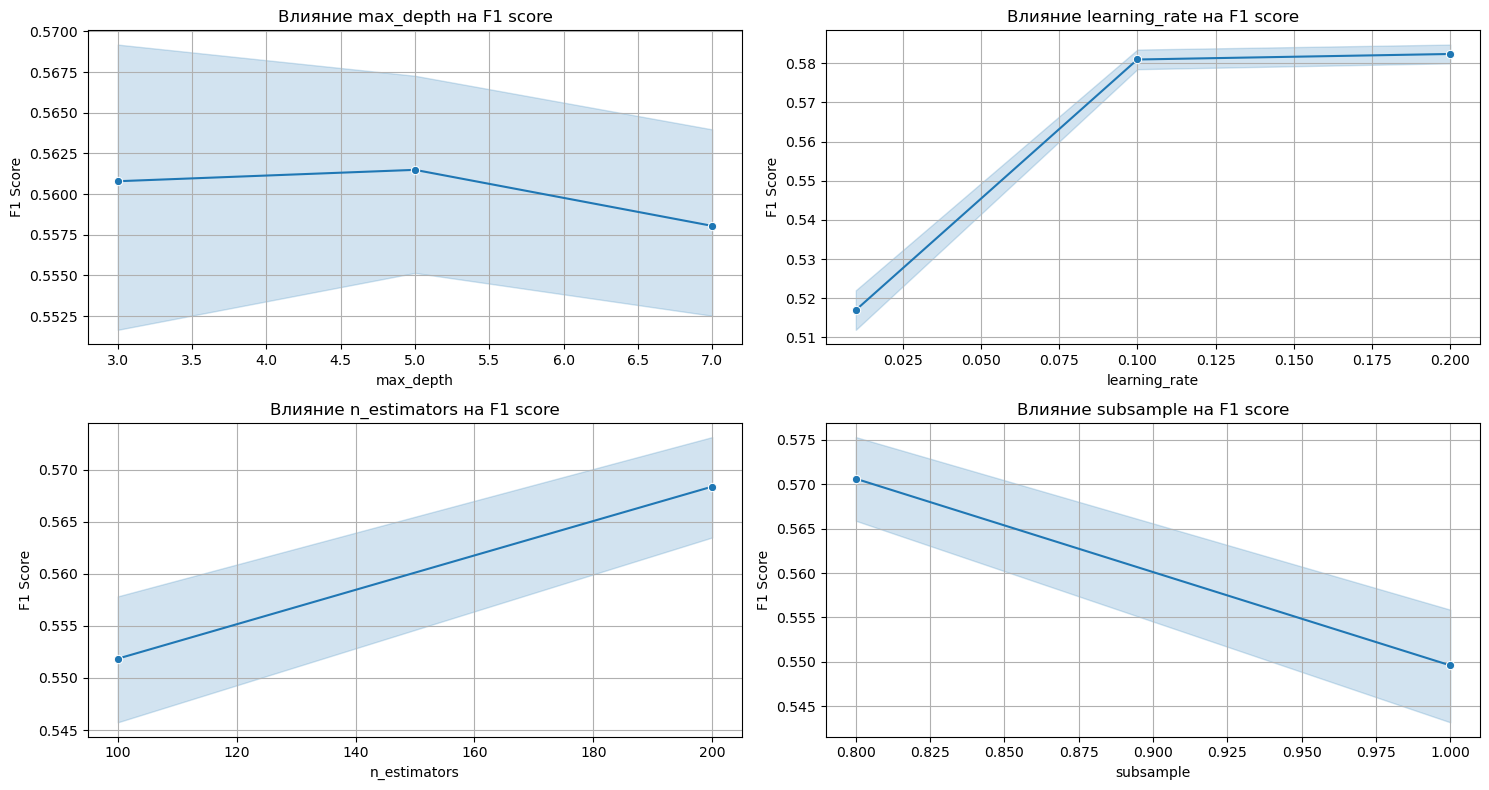

In [10]:
def visualize_cv(cv_results):
    results_df = pd.DataFrame(cv_results)

    plt.figure(figsize=(15, 8))
    
    params_to_plot = ['max_depth', 'learning_rate', 'n_estimators', 'subsample']
    
    for i, param in enumerate(params_to_plot):
        if len(results_df[f'param_{param}'].unique()) > 1:
            plt.subplot(2, 2, i+1)
            
            param_values = [float(str(val)) for val in results_df[f'param_{param}']]
            
            plot_df = pd.DataFrame({
                'param_value': param_values,
                'mean_test_score': results_df['mean_test_score']
            })
            
            plot_df = plot_df.sort_values('param_value')
            
            sns.lineplot(x='param_value', y='mean_test_score', data=plot_df, marker='o')
            plt.title(f'Влияние {param} на F1 score')
            plt.xlabel(param)
            plt.ylabel('F1 Score')
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    

visualize_cv(cv_results)

In [11]:
# import joblib

# joblib.dump(xgb_model, 'author_classifier_xgboost.pkl')
# joblib.dump(label_encoder, 'author_label_encoder.pkl')

In [13]:
def predict_author(text, model, tokenizer, bert_model, label_encoder):
    encoded_input = tokenizer(
        text, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors='pt'
    )
    
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    bert_model.to(device)
    
    with torch.no_grad():
        output = bert_model(**encoded_input)
    
    embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
    
    prediction = model.predict(embedding)
    predicted_author = label_encoder.inverse_transform(prediction)[0]
    
    return predicted_author

    
# Это Пушкин
sample_text = """У Гальяни иль Кольони
Закажи себе в Твери
С пармазаном макарони,
Да яишницу свари."""

predicted_author = predict_author(sample_text, xgb_model, tokenizer, bert_model, label_encoder)
print(f"Предсказанный автор: {predicted_author}")

Предсказанный автор: Куприн Александр Иванович


## Выводы:

### Предобработка текста:
- Использован исходный датасет
- Приведение к нижнему регистру
- Удаление пунктуации и цифр
- Удаление имен авторов и их вариаций для предотвращения "утечки" информации

### Получение эмбеддингов с помощью BERT:
- Используется модель DeepPavlov/rubert-base-cased

### Обучение XGBoost классификатора:
- Применяется GridSearchCV для подбора оптимальных гиперпараметров
- Используется взвешивание классов для решения проблемы несбалансированности датасета

Подсчитываются основные метрики: F1-score, точность, полнота и аккуратность.

**F1-score предыдущих экспериментов превзойти не удалось.** Не удалось к нему даже приблизиться.